In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

from dataset import SyntheticBanditDatasetWithActionEmbeds
from estimator import InversePropensityScore as IPS
from policy import gen_eps_greedy
from util import ActionEmbedOffPolicyEvaluation, aggregate_simulation_results, visualize_mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# setting 1

# 変数
n_actions_list=[250, 500, 1000, 2000]

# 定数
dim_context=5
n_cat_dim=3
n_cat_per_dim=5
latent_param_mat_dim=4
val_size=1000
test_size=100000
eps=0.1
reward_noise=1.0
beta=1.0
n_sim=100
estimator_to_pscore_dict={"IPS": "action", "MIPS": "category"}
random_state=12345

In [22]:
# experiment-1 varying n_actions under the assumption that p(r|x,a,e) = p(r|x,e)

result_df_list = []
for n_actions in n_actions_list:
    
    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_actions,
        dim_context=dim_context,
        n_cat_dim=n_cat_dim,
        n_cat_per_dim=n_cat_per_dim,
        latent_param_mat_dim=latent_param_mat_dim,
        reward_noise=reward_noise,
        beta=beta,
        random_state=random_state
    )

    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
    )
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"n_actions={n_actions}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        evaluation_policy_pscore_dict = dataset.aggregate_propensity_score(
            pi=evaluation_policy, 
            action=val_data["action"],
            action_context=val_data["action_context"],
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            evaluation_policy_pscore=evaluation_policy_pscore_dict
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=n_actions
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

n_actions=250...: 100% 100/100 [00:02<00:00, 42.68it/s]
n_actions=500...: 100% 100/100 [00:04<00:00, 21.85it/s]
n_actions=1000...: 100% 100/100 [00:09<00:00, 11.10it/s]
n_actions=2000...: 100% 100/100 [00:21<00:00,  4.64it/s]


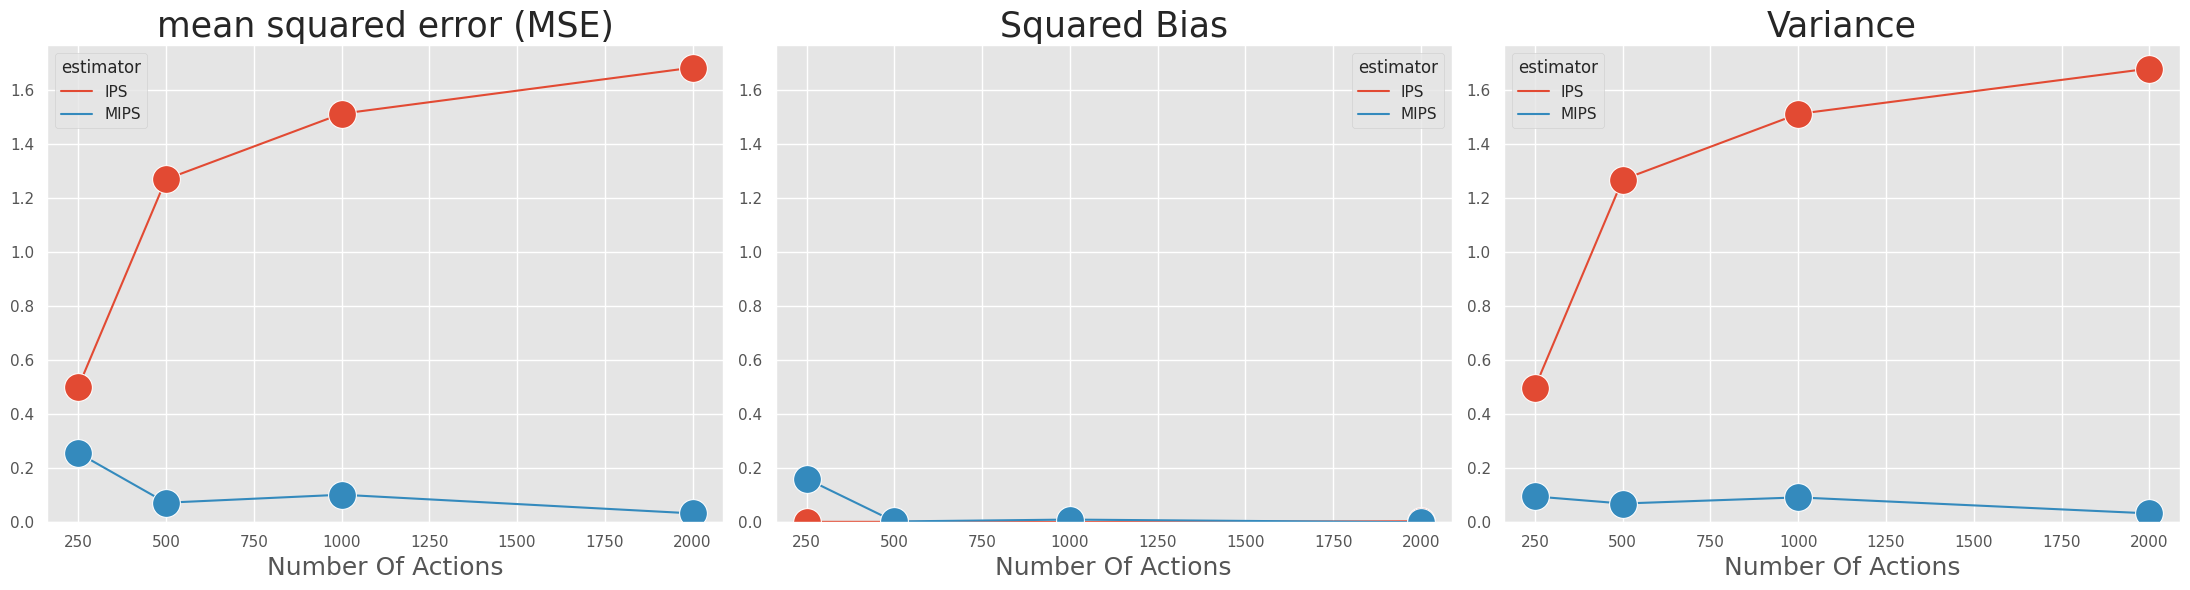

In [23]:
visualize_mean_squared_error(result_df=result_df, xlabel="Number Of Actions")

In [6]:
# setting 2

# 変数
val_size_list=[250, 500, 1000, 2000]

# 定数
dim_context=5
n_cat_dim=3
n_cat_per_dim=10
latent_param_mat_dim=4
n_actions=1000
test_size=100000
eps=0.1
reward_noise=1.0
beta=1.0
n_sim=100
estimator_to_pscore_dict={"IPS": "action", "MIPS": "category"}
random_state=12345

In [7]:
# experiment-2 varying number of data under the assumption that p(r|x,a,e) = p(r|x,e)

dataset = SyntheticBanditDatasetWithActionEmbeds(
    n_actions=n_actions,
    dim_context=dim_context,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    latent_param_mat_dim=latent_param_mat_dim,
    reward_noise=reward_noise,
    beta=beta,
    random_state=random_state
)

test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
policy_value = dataset.calc_ground_truth_policy_value(
    expected_reward=test_data["expected_reward"],
    evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
)
    

result_df_list = []
for val_size in val_size_list:
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        evaluation_policy_pscore_dict = dataset.aggregate_propensity_score(
            pi=evaluation_policy, 
            action=val_data["action"],
            action_context=val_data["action_context"]
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            evaluation_policy_pscore=evaluation_policy_pscore_dict
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=250...: 100% 100/100 [00:03<00:00, 26.13it/s]
val_size=500...: 100% 100/100 [00:07<00:00, 13.72it/s]
val_size=1000...: 100% 100/100 [00:17<00:00,  5.82it/s]
val_size=2000...: 100% 100/100 [00:37<00:00,  2.66it/s]


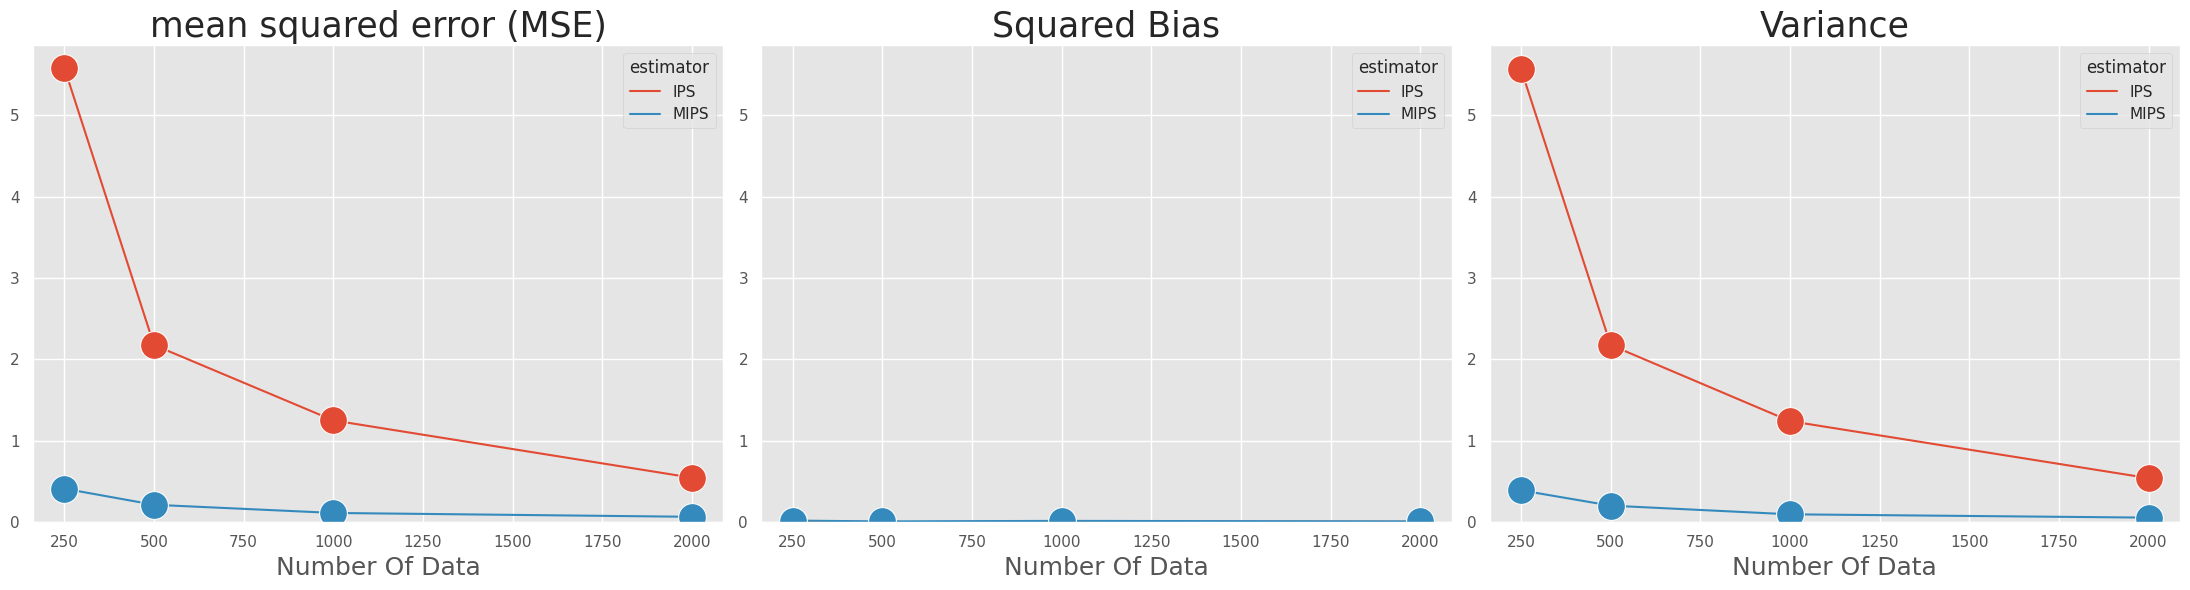

In [8]:
visualize_mean_squared_error(result_df=result_df, xlabel="Number Of Data")

In [15]:
# setting 3

# 変数
n_unobserved_cat_dim_list=[0, 2, 4, 6, 8, 10, 12, 14]

# 定数
dim_context=3
n_cat_dim=15
n_cat_per_dim=2
latent_param_mat_dim=3
n_actions=1000
val_size=10000
test_size=10000
eps=0.1
reward_noise=1.0
beta=1.0
n_sim=100
estimator_to_pscore_dict={"IPS": "action", "MIPS": "category"}
random_state=12345

In [16]:
# experiment-3 varying number of replace category under the assumption that p(r|x,a,e) = p(r|x,e)
    

result_df_list = []
for n_unobserved_cat_dim in n_unobserved_cat_dim_list:
    
    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_actions,
        dim_context=dim_context,
        n_cat_dim=n_cat_dim,
        n_cat_per_dim=n_cat_per_dim,
        latent_param_mat_dim=latent_param_mat_dim,
        reward_noise=reward_noise,
        beta=beta,
        random_state=random_state,
        n_unobserved_cat_dim=n_unobserved_cat_dim
    )

    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
    )
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"n_unobserved_cat_dim={n_unobserved_cat_dim}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        evaluation_policy_pscore_dict = dataset.aggregate_propensity_score(
            pi=evaluation_policy, 
            action=val_data["action"],
            action_context=val_data["action_context"]
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            evaluation_policy_pscore=evaluation_policy_pscore_dict
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=n_unobserved_cat_dim
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

n_unobserved_cat_dim=0...: 100% 100/100 [05:52<00:00,  3.53s/it]
n_unobserved_cat_dim=2...: 100% 100/100 [05:38<00:00,  3.38s/it]
n_unobserved_cat_dim=4...: 100% 100/100 [05:22<00:00,  3.22s/it]
n_unobserved_cat_dim=6...: 100% 100/100 [05:05<00:00,  3.06s/it]
n_unobserved_cat_dim=8...: 100% 100/100 [04:49<00:00,  2.90s/it]
n_unobserved_cat_dim=10...: 100% 100/100 [04:36<00:00,  2.76s/it]
n_unobserved_cat_dim=12...: 100% 100/100 [04:31<00:00,  2.71s/it]
n_unobserved_cat_dim=14...: 100% 100/100 [04:12<00:00,  2.52s/it]


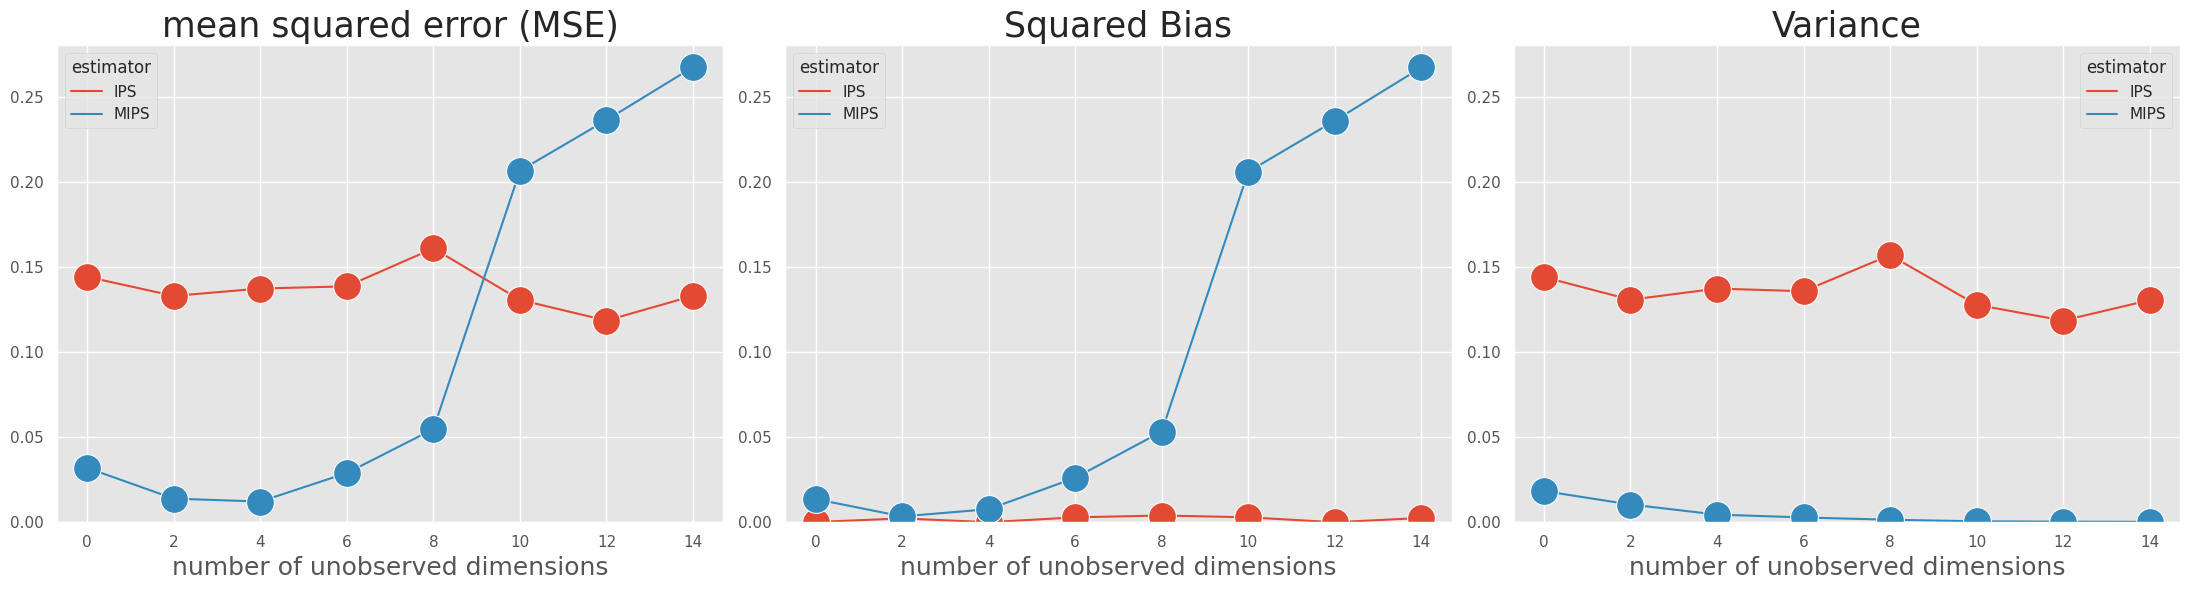

In [17]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of unobserved dimensions")